In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32
IMG_SIZE = 256
CHANNELS = 3
EPOCHS = 10

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"OneDrive/Pictures/PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

Found 16011 files belonging to 10 classes.


In [4]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [5]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 2 4 6 0 7 9 6 6 7 4 7 1 1 0 7 0 7 0 9 0 5 7 2 1 4 7 9 9 1 2 5]


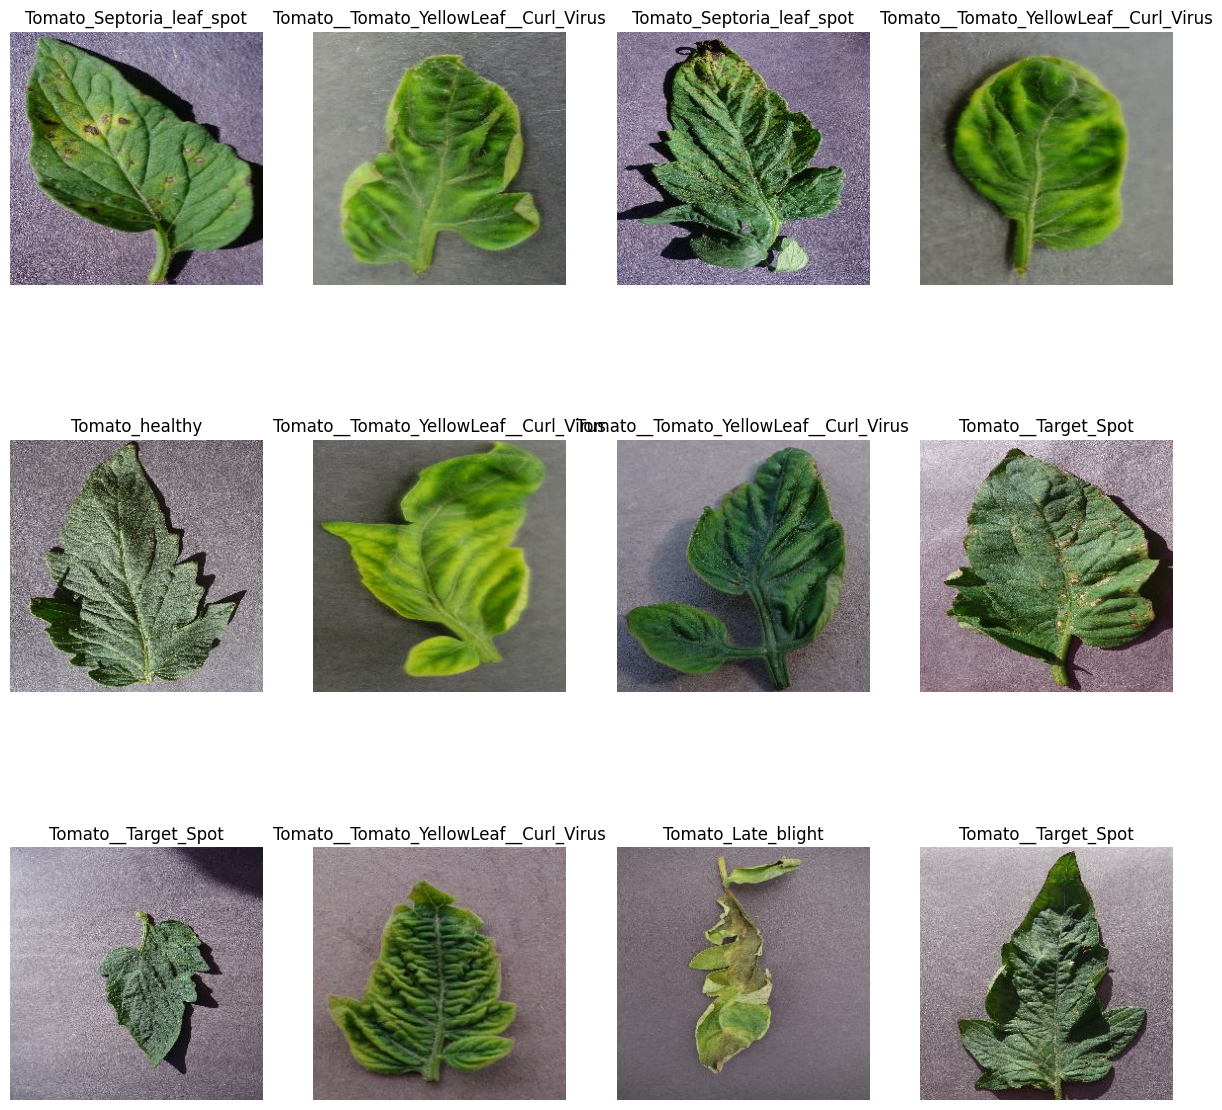

In [6]:
plt.figure(figsize=(15, 15))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
def get_dataset_partition(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=123)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_dataset_partition(dataset)

In [9]:
len(train_ds)

400

In [10]:
len(test_ds), len(val_ds)

(51, 50)

In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
resize_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
])

In [13]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

In [14]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
input_shape = (BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNELS)
n_classes = 10

model = tf.keras.models.Sequential([
    resize_rescale,
    tf.keras.layers.Conv2D(32, kernel_size = (2,2), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64,  kernel_size = (2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64,  kernel_size = (2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (2, 2), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (2, 2), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (2, 2), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 255, 255, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 126, 126, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 63, 63, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 62, 62, 64)         

In [17]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [18]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
400/400 [==============================] - 128s 261ms/step - loss: 1.5123 - accuracy: 0.4641 - val_loss: 1.3725 - val_accuracy: 0.5519
Epoch 2/10
400/400 [==============================] - 70s 174ms/step - loss: 0.7759 - accuracy: 0.7317 - val_loss: 0.9936 - val_accuracy: 0.6569
Epoch 3/10
400/400 [==============================] - 72s 179ms/step - loss: 0.5623 - accuracy: 0.8031 - val_loss: 0.8571 - val_accuracy: 0.7237
Epoch 4/10
400/400 [==============================] - 71s 177ms/step - loss: 0.4478 - accuracy: 0.8428 - val_loss: 0.5520 - val_accuracy: 0.8131
Epoch 5/10
400/400 [==============================] - 70s 175ms/step - loss: 0.3803 - accuracy: 0.8638 - val_loss: 0.4658 - val_accuracy: 0.8375
Epoch 6/10
400/400 [==============================] - 72s 179ms/step - loss: 0.3252 - accuracy: 0.8859 - val_loss: 0.8002 - val_accuracy: 0.7625
Epoch 7/10
400/400 [==============================] - 71s 178ms/step - loss: 0.2958 - accuracy: 0.8960 - val_loss: 0.4748 - val_a

In [19]:
scores = model.evaluate(test_ds)

51/51 [==============================] - 33s 67ms/step - loss: 0.6087 - accuracy: 0.8223


In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

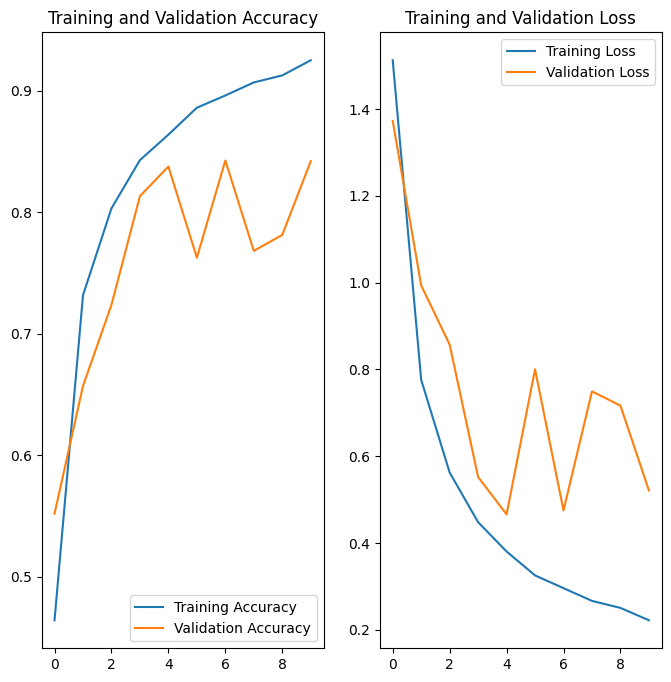

In [21]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Tomato_healthy
1/1 [==============================] - 1s 844ms/step
predicted label: Tomato_healthy


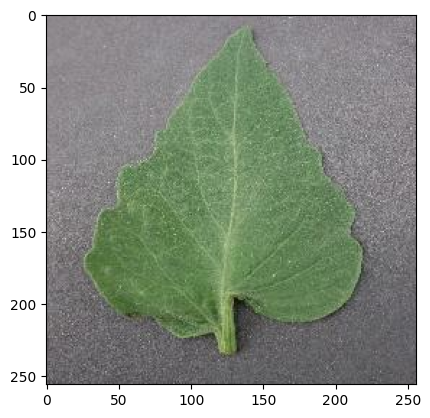

In [22]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [23]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 50ms/step


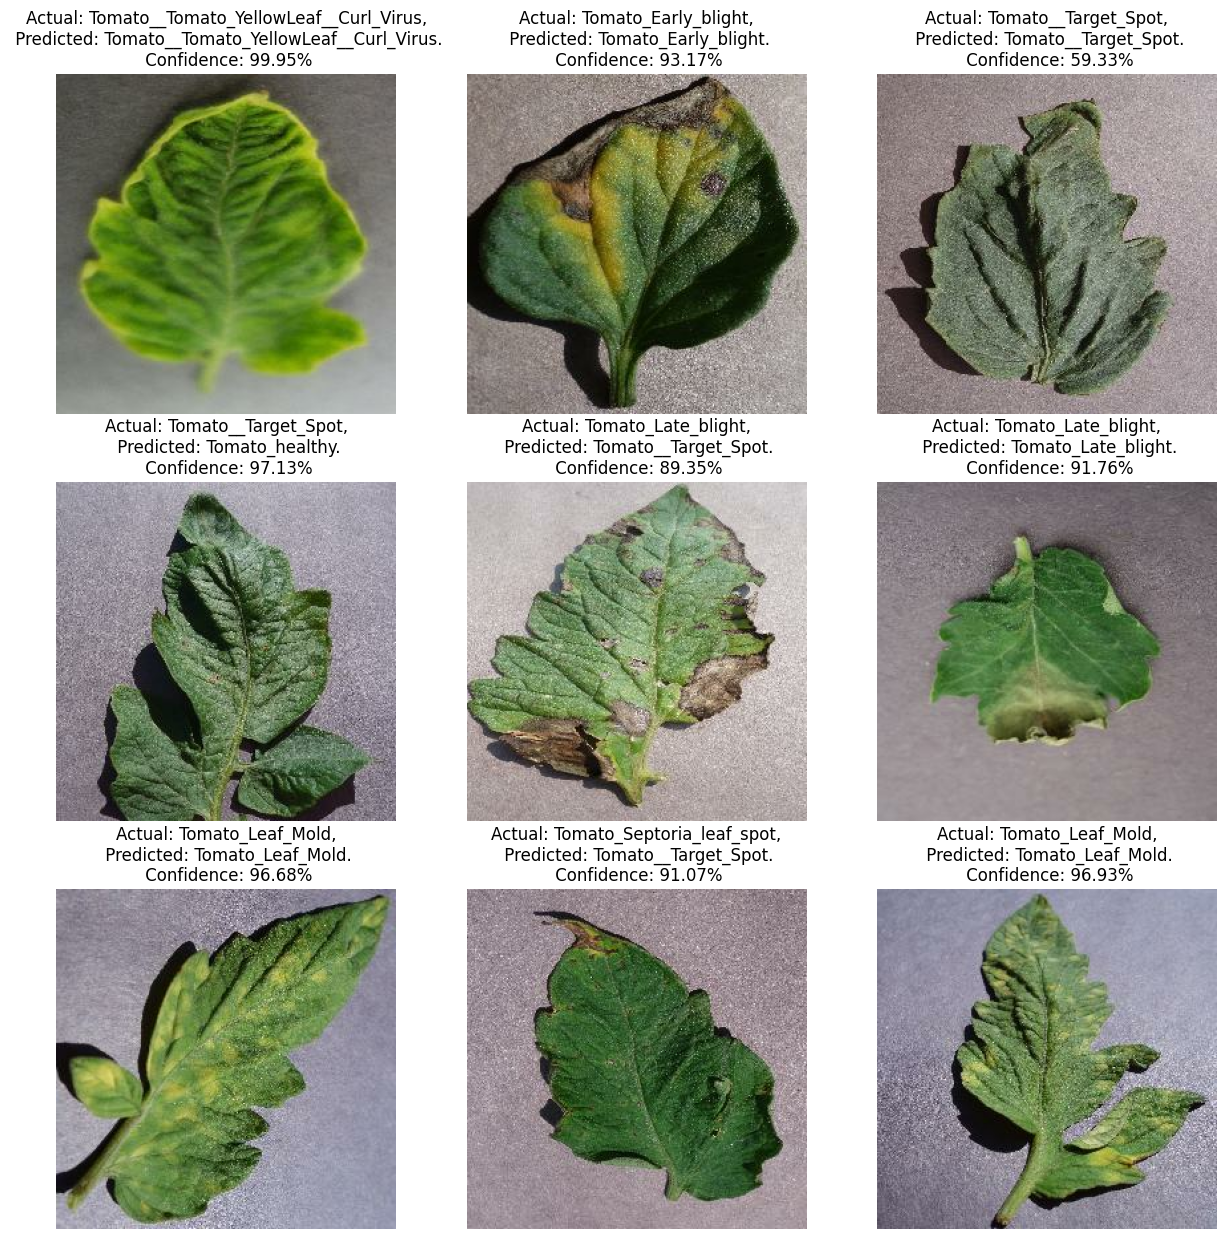

In [24]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")